In [1]:
from langgraph.graph import StateGraph, MessagesState, END
from typing import TypedDict

class ConxualizedKeyword(TypedDict):
    keyword: str
    context: str

class ConxualizedCitation(TypedDict):
    citation: str
    abstract: str
    context: str

class ConxualizedKeywordList(TypedDict):
    keywords: list[ConxualizedKeyword]

class ConxualizedCitationList(TypedDict):
    citations: list[ConxualizedCitation]

# Define the state with a built-in messages key
class ResearchState(MessagesState):
    paper_md: str
    keywords: ConxualizedKeywordList
    citations: ConxualizedCitationList
    reading_assistance_md: str

# Define the logic for each node
def input_node(state: ResearchState) -> ResearchState:
    # Logic to process the input paper
    return {"messages": [("system", "Input paper processed")]}


def keyword_extraction_node(state: ResearchState) -> ResearchState:
    # Logic to extract keywords
    return {"keywords": ["keyword1", "keyword2"]}


def citation_extraction_node(state: ResearchState) -> ResearchState:
    # Logic to extract citations
    return {"citations": ["citation1", "citation2"]}


def contextualization_node(state: ResearchState) -> ResearchState:
    # Logic to add context to keywords and citations
    return {"context": "contextualized information"}


def abstract_fetching_node(state: ResearchState) -> ResearchState:
    # Logic to fetch abstracts for citations
    return {"abstracts": ["abstract1", "abstract2"]}


def reading_assistance_node(state: ResearchState) -> ResearchState:
    # Logic to provide reading assistance
    return {"reading_assistance": "assistance context"}


def final_contextualization_node(state: ResearchState) -> ResearchState:
    # Logic to finalize the contextualization
    return {"messages": [("system", "Final contextualization complete")]}


# Create the graph
graph = StateGraph(ResearchState)

# Add nodes to the graph
graph.add_node("input_node", input_node)
graph.add_node("keyword_extraction_node", keyword_extraction_node)
graph.add_node("citation_extraction_node", citation_extraction_node)
graph.add_node("contextualization_node", contextualization_node)
graph.add_node("abstract_fetching_node", abstract_fetching_node)
graph.add_node("reading_assistance_node", reading_assistance_node)
graph.add_node("final_contextualization_node", final_contextualization_node)

# Define the edges between nodes
graph.set_entry_point("input_node")
graph.add_edge("input_node", "keyword_extraction_node")
graph.add_edge("input_node", "citation_extraction_node")
graph.add_edge("keyword_extraction_node", "contextualization_node")
graph.add_edge("citation_extraction_node", "contextualization_node")
graph.add_edge("citation_extraction_node", "abstract_fetching_node")
graph.add_edge("contextualization_node", "reading_assistance_node")
graph.add_edge("abstract_fetching_node", "reading_assistance_node")
graph.add_edge("reading_assistance_node", "final_contextualization_node")
graph.set_finish_point("final_contextualization_node")

# Compile the graph
app = graph.compile()

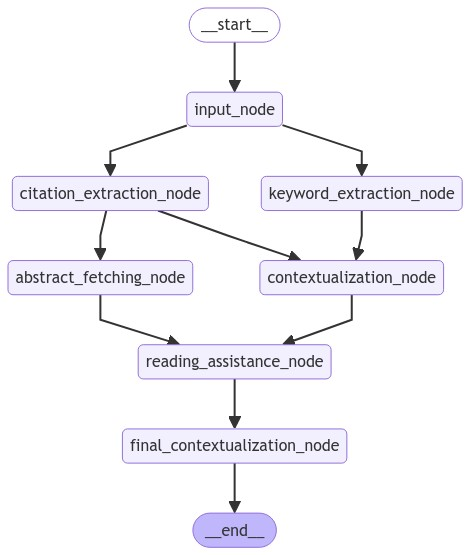

In [2]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))